In [1]:
%cd /content/drive/MyDrive/Colab\ Notebooks/입찰/LSTM

/content/drive/MyDrive/Colab Notebooks/입찰/LSTM


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, concatenate
from keras.optimizers import Adam, RMSprop

In [3]:
data = np.loadtxt('./data.csv', delimiter=',')#########파일 넣는 곳################
data = data.reshape(-1,1)
#data = data[-2000:]

train_raw = data[:int(len(data)*0.9)] # train
test_raw = data[-(len(data)-len(train_raw)):] # test

sc1 = MinMaxScaler(feature_range=(0,1))
scaled_train = sc1.fit_transform(train_raw) # scaled train
scaled_test = sc1.fit_transform(test_raw) # scaled test

In [4]:
def datamake(data):
  ndata = []
  c = 3
  for i in range(len(data)-1):
    ndata.append(data[i])
    sum = data[i] + data[i+1]
    mean = sum / 2
    for j in range(c):
      if j==0:
        mean2 = (mean+data[i]) / 2
      elif j==1:
        mean2 = mean
      elif j==2:
        mean2 = (mean+data[i+1]) / 2
      ndata.append(mean2)
  ndata.append(data[-1])
  ndata = np.array(ndata)
  return ndata

In [5]:
train_added_scaled = datamake(scaled_train)
test_added_scaled = datamake(scaled_test)

In [6]:
print(train_added_scaled.shape)
print(test_added_scaled.shape)

(9769, 1)
(1085, 1)


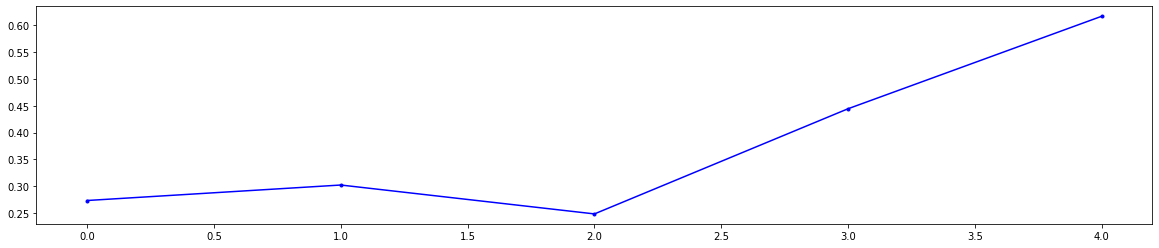

In [7]:
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(scaled_train[-5:,:], '.-',color = 'blue', label = 'GroundTruth')

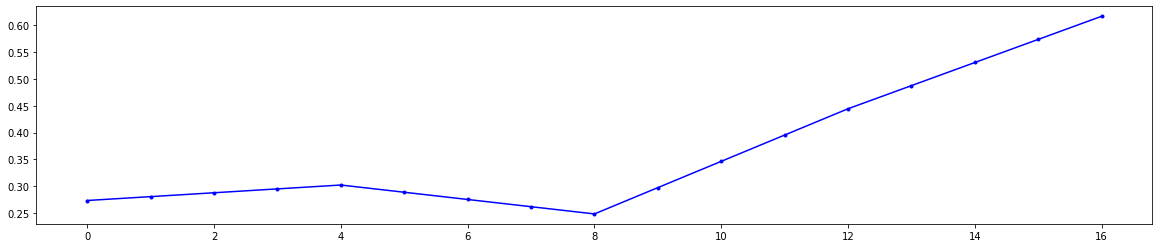

In [9]:
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(train_added_scaled[-17:,:], '.-',color = 'blue', label = 'GroundTruth')

In [10]:
seq_length = 50 ############## 6, 7

In [11]:
def make_data(train):
    X_train = [] 
    Y_train = []
    for i in range(seq_length, train.shape[0]):
        X_train.append(train[i-seq_length:i, 0])
        Y_train.append(train[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    return X_train, Y_train

In [12]:
X_train, Y_train = make_data(train_added_scaled) # train_added_scaled
X_test, Y_test = make_data(test_added_scaled) # test_added_scaled

In [13]:
inputs = Input(shape = (seq_length, 1))
x = LSTM(32, return_sequences=True)(inputs)
x = Dropout(0.5)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.5)(x)

y = LSTM(64, return_sequences=True)(inputs)
y = Dropout(0.5)(y)
y = LSTM(128, return_sequences=True)(y)
y = Dropout(0.5)(y)

concat = concatenate([x, y])
output = LSTM(256 ,return_sequences=False)(concat)
output = Dropout(0.5)(output)
output = Dense(1)(output)
model = Model(inputs = inputs, outputs = output)

#model.summary()

In [14]:
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X_train, Y_train, epochs = 50, batch_size = 10, validation_split=0.1)

Epoch 1/50
875/875 [==============================] - 28s 19ms/step - loss: 0.0187 - val_loss: 0.0049
Epoch 2/50
875/875 [==============================] - 15s 17ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 3/50
875/875 [==============================] - 15s 17ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 4/50
875/875 [==============================] - 15s 17ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 5/50
875/875 [==============================] - 15s 17ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 6/50
875/875 [==============================] - 15s 17ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 7/50
875/875 [==============================] - 15s 17ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 8/50
875/875 [==============================] - 15s 17ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 9/50
875/875 [==============================] - 15s 17ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 10/50
875/875 [==============================] - 15s 17ms/step - loss: 0.002

In [15]:
predicted_X_train = model.predict(X_train)
predicted_X_train = sc1.inverse_transform(predicted_X_train)
train = sc1.inverse_transform(train_added_scaled)
mean_train_error = np.average(np.abs(train[seq_length:,:] - predicted_X_train))

print("평균 training error:", mean_train_error)

평균 training error: 0.029890620289271367


In [16]:
predicted_X_test = model.predict(X_test)
predicted_X_test = sc1.inverse_transform(predicted_X_test)
test = sc1.inverse_transform(test_added_scaled)
mean_test_error = np.average(np.abs(test[seq_length:,:] - predicted_X_test))

print("평균 test error:", mean_test_error)

평균 test error: 0.03575104115365856


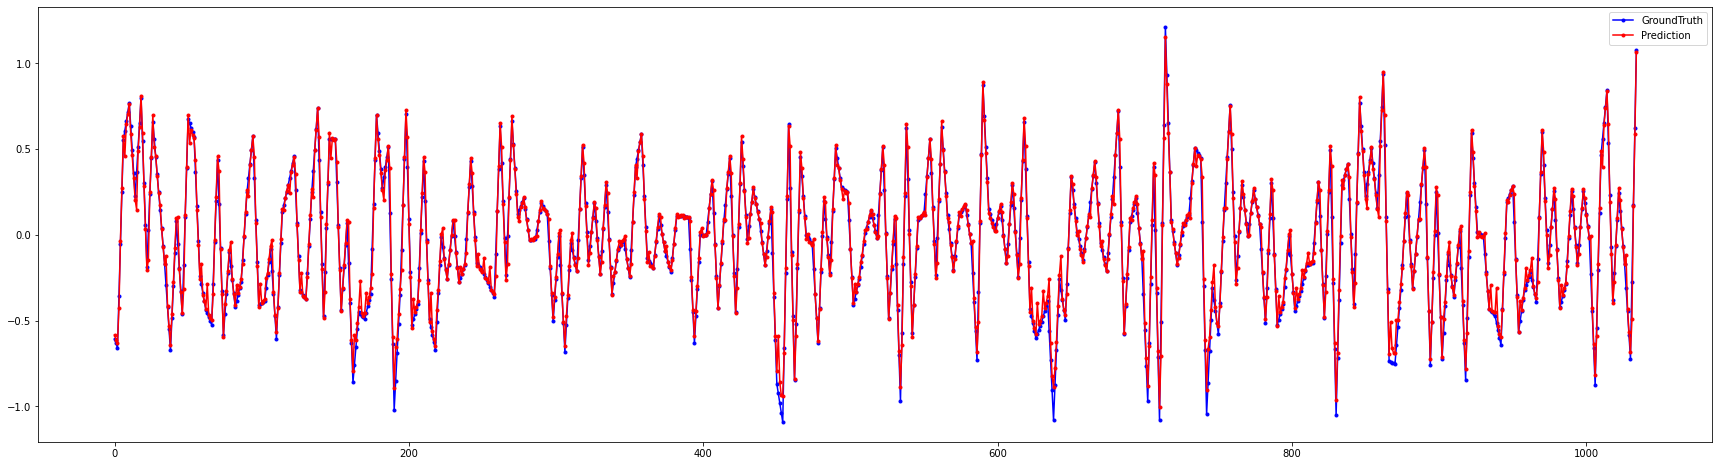

In [17]:
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(test[seq_length:,:], '.-',color = 'blue', label = 'GroundTruth')
plt.plot(predicted_X_test, '.-',color = 'red', label = 'Prediction')
plt.legend()
plt.savefig('LSTM3_test')

In [18]:
pred1 = model.predict(test_added_scaled[-seq_length:].reshape(1,seq_length,1)) # temp_pred 1
dummy = test_added_scaled[-seq_length:] 
dummy = np.append(dummy, pred1, axis=0) 

pred2 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred 2
dummy = np.append(dummy, pred2, axis=0) 

pred3 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred 3
dummy = np.append(dummy, pred3, axis=0)

pred4 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) ############## first
dummy = np.append(dummy, pred4, axis=0) 

pred5 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred1
dummy = np.append(dummy, pred5, axis=0)

pred6 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred2
dummy = np.append(dummy, pred6, axis=0)

pred7 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred3
dummy = np.append(dummy, pred7, axis=0) 

pred8 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) ############## second
dummy = np.append(dummy, pred4, axis=0) 

pred9 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred1
dummy = np.append(dummy, pred9, axis=0)

pred10 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred2
dummy = np.append(dummy, pred10, axis=0)

pred11 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) # temp_pred3
dummy = np.append(dummy, pred11, axis=0) 

pred12 = model.predict(dummy[-seq_length:].reshape(-1,seq_length,1)) ############## third

result1 = sc1.inverse_transform(pred4)
result2 = sc1.inverse_transform(pred8)
result3 = sc1.inverse_transform(pred12)
print('Predict1 : ', result1)
print('Predict2 : ', result2)
print('Predict3 : ', result3)

Predict1 :  [[-0.2603061]]
Predict2 :  [[-0.00625633]]
Predict3 :  [[0.07721355]]


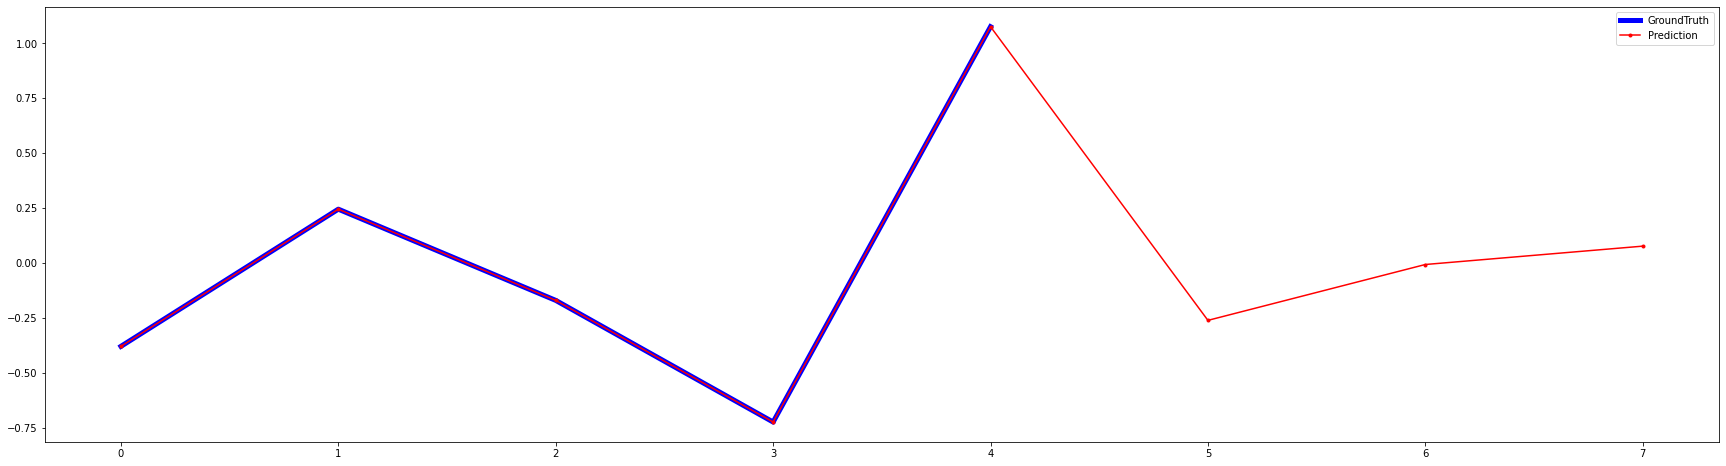

In [19]:
dum = test_raw[-5:]
dum = np.append(dum, result1)
dum = np.append(dum, result2)
dum = np.append(dum, result3)
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(test_raw[-5:], '.-',color = 'blue', label = 'GroundTruth', linewidth=5.0)
plt.plot(dum, '.-',color = 'red', label = 'Prediction')
plt.legend()
plt.savefig('LSTM3_predict')